In [97]:
from pystencils.session import *
sp.init_printing()
frac = sp.Rational
import time


In [98]:
dh = ps.create_data_handling(domain_size=(150, 150), periodicity=True,
                             default_target='cpu')
φ_field = dh.add_array('phi', latex_name='φ')
φ_field_tmp = dh.add_array('phi_temp', latex_name='φ_temp')
φ_delta_field = dh.add_array('phidelta', latex_name='φ_D')
t_field = dh.add_array('T')

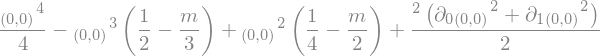

In [99]:
ε, m, δ, j, θzero, α, γ, Teq, κ, τ = sp.symbols("ε m δ j θ_0 α γ T_eq κ τ")
εb = sp.Symbol("\\bar{\\epsilon}")

φ = φ_field.center
φ_tmp = φ_field_tmp.center
T = t_field.center

def f(φ, m):
    return φ**4 / 4 - (frac(1, 2) - m/3) * φ**3 + (frac(1,4)-m/2)*φ**2

free_energy_density = ε**2 / 2 * (ps.fd.Diff(φ,0)**2 + ps.fd.Diff(φ,1)**2 ) + f(φ, m)
free_energy_density

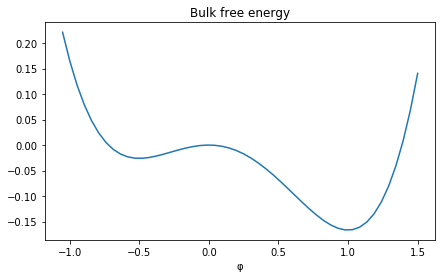

In [100]:
plt.figure(figsize=(7,4))
plt.sympy_function(f(φ, m=1), x_values=(-1.05, 1.5) )
plt.xlabel("φ")
plt.title("Bulk free energy");

In [101]:
def σ(θ):
    return 1 + δ * sp.cos(j * (θ - θzero))

θ = sp.atan2(ps.fd.Diff(φ, 1), ps.fd.Diff(φ, 0))

ε_val = εb * σ(θ)
ε_val

In [102]:
def m_func(T):
    return (α / sp.pi) * sp.atan(γ * (Teq - T))

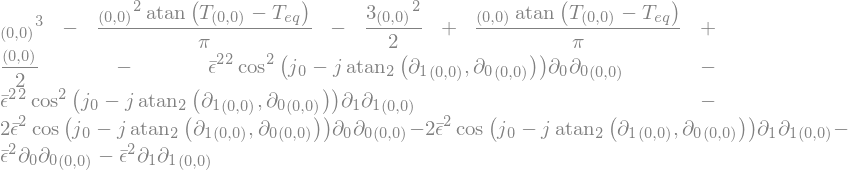

In [103]:
fe = free_energy_density.subs({
    m: m_func(T),
    ε: εb * σ(θ),
})

dF_dφ = ps.fd.functional_derivative(fe, φ)
dF_dφ = ps.fd.expand_diff_full(dF_dφ, functions=[φ])
dF_dφ

In [104]:
discretize = ps.fd.Discretization2ndOrder(dx=0.03, dt=1e-5)
parameters = {
    τ: 0.0003,
    κ: 1.8,
    εb: 0.01,
    δ: 0.02,
    γ: 10,
    j: 6,
    α: 0.9,
    Teq: 1.0,
    θzero: 0.2,
    sp.pi: sp.pi.evalf()
}
parameters


In [105]:
dφ_dt = - dF_dφ / τ
φ_eqs = ps.simp.sympy_cse_on_assignment_list([ps.Assignment(φ_delta_field.center,
                                                            discretize(dφ_dt.subs(parameters)))])
φ_eqs.append(ps.Assignment(φ_tmp, discretize(ps.fd.transient(φ) - φ_delta_field.center)))

temperature_evolution = -ps.fd.transient(T) + ps.fd.diffusion(T, 1) + κ * φ_delta_field.center
temperature_eqs = [
    ps.Assignment(T, discretize(temperature_evolution.subs(parameters)))
]

In [106]:
φ_kernel = ps.create_kernel(φ_eqs, cpu_openmp=4, target=dh.default_target).compile()
temperature_kernel = ps.create_kernel(temperature_eqs, target=dh.default_target).compile()


In [107]:
def timeloop(steps=200):
    φ_sync = dh.synchronization_function(['phi'])
    temperature_sync = dh.synchronization_function(['T'])
    dh.all_to_gpu()  # this does nothing when running on CPU
    for t in range(steps):
        φ_sync()
        dh.run_kernel(φ_kernel)
        dh.swap('phi', 'phi_temp')
        temperature_sync()
        dh.run_kernel(temperature_kernel)
    dh.all_to_cpu()
    return dh.gather_array('phi')

def init(nucleus_size=np.sqrt(5)):
    for b in dh.iterate():
        x, y = b.cell_index_arrays
        x, y = x-b.shape[0]//2, y-b.shape[0]//2
        bArr = (x**2 + y**2) < nucleus_size**2
        b['phi'].fill(0)
        b['phi'][(x**2 + y**2) < nucleus_size**2] = 1.0
        b['T'].fill(0.0)

def plot():
    plt.subplot(1,3,1)
    plt.scalar_field(dh.gather_array('phi'))
    plt.title("φ")
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("T")
    plt.scalar_field(dh.gather_array('T'))
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("∂φ")
    plt.scalar_field(dh.gather_array('phidelta'))
    plt.colorbar()


    Name|      Inner (min/max)|     WithGl (min/max)
----------------------------------------------------
       T|            (  0,  0)|            (  0,  0)
     phi|            (  0,  1)|            (  0,  1)
phi_temp|            (nan,nan)|            (nan,nan)
phidelta|            (nan,nan)|            (nan,nan)



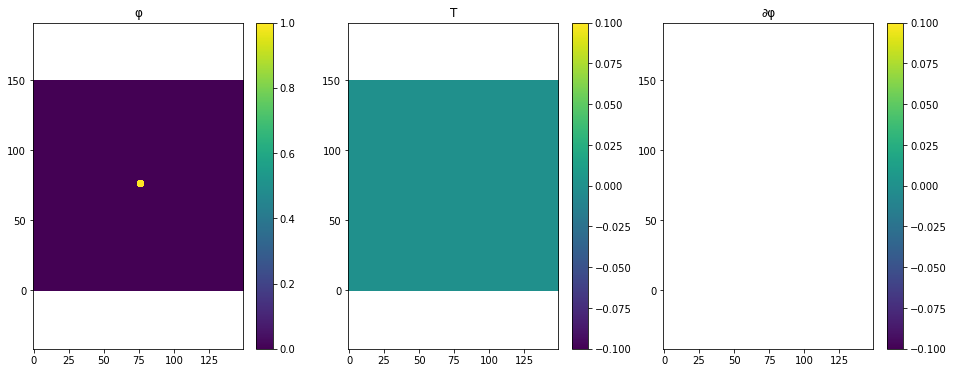

In [108]:

timeloop(10)
init()
plot()
print(dh)

In [109]:
start = time.clock()
result = None
if 'is_test_run' not in globals():
    ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=600)
    result = ps.jupyter.display_as_html_video(ani)
end = time.clock()
result

In [110]:
print(end-start)

1304.1847820000003
